In [17]:
import os
import multiprocessing as mp

import cv2
import glob2
import pydicom
from tqdm import tqdm
import zipfile
import io
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import exposure

import sys
sys.path.insert(0, '../../data/siim-pneumothorax')
from mask_functions import *

In [18]:
sz = 1024
sz0 = 1024

data_root = '../../data/siim-pneumothorax'
PATH_TRAIN = os.path.join(data_root, 'dicom-images-train/')
PATH_TEST = os.path.join(data_root, 'dicom-images-test/')

train_out = os.path.join(data_root, 'train_{}.zip'.format(sz))
test_out = os.path.join(data_root, 'test_{}.zip'.format(sz))
mask_out = os.path.join(data_root, 'masks_{}.zip'.format(sz))

train = glob2.glob(os.path.join(PATH_TRAIN, '**/*.dcm'))
test = glob2.glob(os.path.join(PATH_TEST, '**/*.dcm'))

In [19]:
df = pd.read_csv(os.path.join(data_root, 'train-rle.csv')).set_index('ImageId')
idxs = set(df.index)
train_names = []
for f in train: #remove images without labels
    name = f.split('/')[-1][:-4]
    if name in idxs: train_names.append(f)

In [20]:
def convert_images(filename, arch_out, sz=sz):
    ds = pydicom.read_file(str(filename))
    img = ds.pixel_array
    img = cv2.resize(img, (sz, sz))
    img = exposure.equalize_adapthist(img) # contrast correction
    x_tot = img.mean() #image statistics
    x2_tot = (img**2).mean()
    img = ((img*255)).clip(0,255).astype(np.uint8)
    output = cv2.imencode('.png',img)[1]
    name = filename.split('/')[-1][:-4] + '.png'
    arch_out.writestr(name, output)
    return x_tot, x2_tot

def get_stats(stats): # get dataset statistics 
    x_tot, x2_tot = 0.0, 0.0
    for x, x2 in stats:
        x_tot += x
        x2_tot += x2
    
    img_avr =  x_tot/len(stats)
    img_std =  np.sqrt(x2_tot/len(stats) - img_avr**2)
    print('mean:',img_avr, ', std:', img_std)


In [21]:
trn_stats = []
with zipfile.ZipFile(train_out, 'w') as arch:
    for fname in tqdm(train_names, total=len(train_names), file=sys.stdout):
        trn_stats.append(convert_images(fname,arch))

test_stats = []        
with zipfile.ZipFile(test_out, 'w') as arch:
    for fname in tqdm(test, total=len(test), file=sys.stdout):
        test_stats.append(convert_images(fname,arch))


100%|██████████| 1377/1377 [01:22<00:00, 16.74it/s]


In [22]:
get_stats(trn_stats)
get_stats(test_stats)

mean: 0.5213446849925896 , std: 0.2542653719896987
mean: 0.5188847691560136 , std: 0.2546409761578355


In [23]:
mask_coverage = []
mask_count = 0
with zipfile.ZipFile(mask_out, 'w') as arch:
    for idx in tqdm(idxs):
        masks = df.loc[idx,' EncodedPixels']
        img = np.zeros((sz0,sz0))
        #do conversion if mask is not " -1"
        if(type(masks) != str or (type(masks) == str and masks != ' -1')):
            if(type(masks) == str): masks = [masks]
            else: masks = masks.tolist()
            mask_count +=1
            for mask in masks:
                img += rle2mask(mask, sz0, sz0).T
        mask_coverage.append(img.mean())
        img = cv2.resize(img, (sz, sz))
        output = cv2.imencode('.png',img)[1]
        name = idx + '.png'
        arch.writestr(name, output)

print('mask coverage:', np.mean(mask_coverage)/255, ', mask count:', mask_count)

100%|██████████| 10675/10675 [00:54<00:00, 194.35it/s]

mask coverage: 0.0031809534792040213 , mask count: 2379


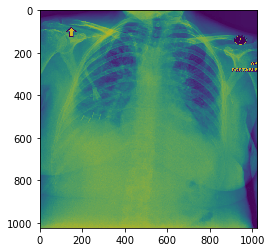

In [24]:
idx = 2
with zipfile.ZipFile(train_out, 'r') as arch:
    fname = sorted(arch.namelist())[idx]
    flags = cv2.IMREAD_GRAYSCALE
    img = cv2.imdecode(np.frombuffer(arch.read(fname), np.uint8), flags)
    
with zipfile.ZipFile(mask_out, 'r') as arch:
    fname = sorted(arch.namelist())[idx]
    flags = cv2.IMREAD_GRAYSCALE
    mask = cv2.imdecode(np.frombuffer(arch.read(fname), np.uint8), flags)
    
plt.figure()
plt.imshow(Image.fromarray(img))
plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()